**All the files and models, created in this notebook, may be found [here](https://drive.google.com/file/d/1kxNLaHLgJ6RmVK9M__5zPJ0R8r1OzD4g/view?usp=sharing).**

In [4]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
from utils_unet import UNet, BrainSegmentationDataset, train_validate, data_loaders, save_images

# Helpers

In [5]:
def report_sparcity(model, verbose=0):
  zero_total = 0
  n_total = 0
  for n, x in model.named_parameters():
    if 'weight' in n:
      attrs = n.split('.')
      obj = model
      for attr in attrs[:-1]:
        obj = getattr(obj, attr)
 
      zeros = (obj.weight.data == 0).sum()
      l = len(torch.flatten(obj.weight))
 
      zero_total += zeros
      n_total += l
 
      if verbose > 0:
        print(f'Layer: {n}, 0-weights ratio: {zeros/l:.4}')
 
  return zero_total/n_total

def monotonize(model, pos=True, ignore_last=True):
  for n, x in model.named_parameters():
    if 'weight' in n:
      if ignore_last and n == 'conv.weight':
        continue
      attrs = n.split('.')
      obj = model
      for attr in attrs[:-1]:
        obj = getattr(obj, attr)
 
      if pos:
        obj.weight.data = obj.weight.data.clip(min=0)
      else:
        obj.weight.data = obj.weight.data.clip(max=0) 

In [6]:
def res_to_df(res, name, mono, l1):
    train = len(res[0]) // 30
    val = len(res[1]) // 30
    results = pd.DataFrame({
        'train_mean_loss': [np.mean(res[0][i:i+train]) for i in range(0, len(res[0]), train)],
        'val_mean_loss': [np.mean(res[1][i:i+val]) for i in range(0, len(res[1]), val)],
        'mean_sparsity': [np.mean(res[2][i:i+train]) for i in range(0, len(res[2]), train)],
        'epoch': [i+1 for i in range(30)],
        'mean_val_dsc': res[3],
        'l1': [l1 for _ in range(30)],
        'mono': [mono for _ in range(30)],
        'name': [name for _ in range(30)]
    })
    return results

def show_results(res):
  _, ax = plt.subplots(1, 2, figsize=(20, 4))

  ax[0].plot(range(1, 31), res['train_mean_loss'], label='train')
  ax[0].plot(range(1, 31), res['val_mean_loss'], label='validation')
  ax[0].set_xlabel('epoch', fontsize=14)
  ax[0].set_title('BCELoss', fontsize=14)
  ax[0].legend();

  ax[1].plot(range(1, 31), res['mean_val_dsc'])
  ax[1].set_title('Mean DSC score on validation', fontsize=14)
  ax[1].set_xlabel('epoch', fontsize=14)
  plt.show()

  plt.plot(range(1, 31), res['mean_sparsity'])
  plt.title('Model mean sparsity (0-weights ratio)')
  plt.xlabel('epoch', fontsize=14);    

In [7]:
# code from seminar11 
def get_accuracy(model, dataloader, device):
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            prediction = (model(x) > 0.5)
            correct += prediction.eq(y.view_as(prediction)).sum().item()
    return correct / (len(dataloader.dataset) * (image_size**2))



# Dataset creation


In [8]:
# mount google drive and import dataset to colab
# uncomment if necessary
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# !cp "/content/drive/MyDrive/input/lgg-mri-segmentation.zip" .
# !unzip -q "lgg-mri-segmentation.zip"
# !rm "lgg-mri-segmentation.zip"

In [10]:
batch_size = 16
workers = 2
image_size = 256
aug_scale = 0.05
aug_angle = 15
path = 'lgg-mri-segmentation/kaggle_3m' # prive a path to the dataset folder
    
loader_train, loader_valid = data_loaders(batch_size, workers, image_size, 
                                          aug_scale, aug_angle, path)
loaders = {"train": loader_train, "valid": loader_valid}

reading train images...
preprocessing train volumes...
normalizing train volumes...
done creating train dataset
reading validation images...
preprocessing validation volumes...
normalizing validation volumes...
done creating validation dataset


# U-Net

In [ ]:
unet = UNet(in_channels=BrainSegmentationDataset.in_channels, 
                 out_channels=BrainSegmentationDataset.out_channels,
                 init_features=32, p=0)

In [ ]:
res = train_validate(unet, loaders, report_sparcity, 
                     name='unet', lr=1e-4, monotonize=None,
                     schedule='step', loss_func=torch.nn.BCELoss(reduction='sum'))

epoch 1 | loss: 527975.890327381
epoch 1 | val_loss: 443289.0416666667
epoch 1 | val_dsc: 0.6737110252234436
epoch 2 | loss: 403539.37351190473
epoch 2 | val_loss: 365546.2529761905
epoch 2 | val_dsc: 0.7370503833651469
epoch 3 | loss: 347681.93273809523
epoch 3 | val_loss: 319577.41220238095
epoch 3 | val_dsc: 0.7758129053985415
epoch 4 | loss: 319358.81875
epoch 4 | val_loss: 314508.4568452381
epoch 4 | val_dsc: 0.82382164902654
epoch 5 | loss: 314247.0568452381
epoch 5 | val_loss: 309896.5848214286
epoch 5 | val_dsc: 0.833300273665782
epoch 6 | loss: 309386.6619047619
epoch 6 | val_loss: 305443.84375
epoch 6 | val_dsc: 0.8364952349440655
epoch 7 | loss: 304593.48169642856
epoch 7 | val_loss: 301193.70386904763
epoch 7 | val_dsc: 0.8394189226984261
epoch 8 | loss: 299861.8400297619
epoch 8 | val_loss: 296891.22321428574
epoch 8 | val_dsc: 0.8421977465807593
epoch 9 | loss: 295190.4300595238
epoch 9 | val_loss: 292634.1592261905
epoch 9 | val_dsc: 0.8438630044776086
epoch 10 | loss: 2

In [ ]:
results = res_to_df(res, 'unet', mono='-', l1=0)
results.to_csv('res.csv', index=False)

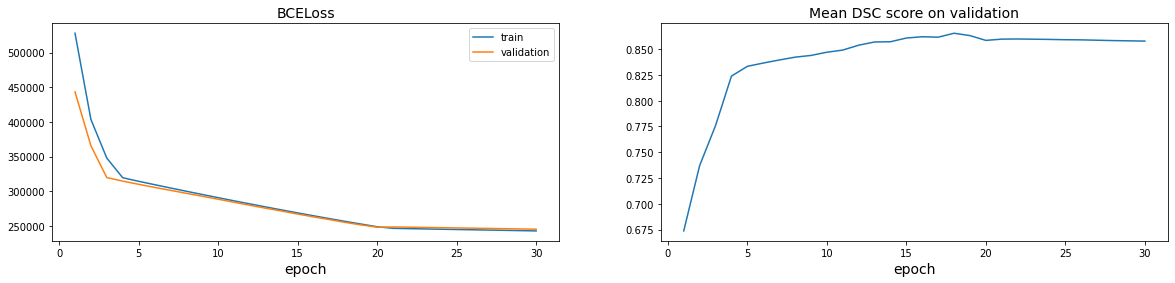

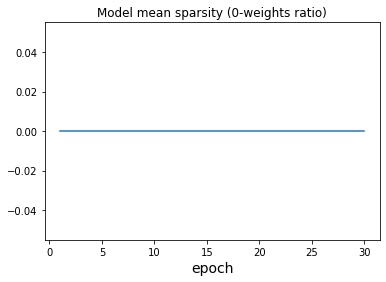

In [ ]:
show_results(results)

In [ ]:
get_accuracy(unet, loaders['valid'], 'cuda:0')    

0.997062888074277

In [ ]:
# saving the resulting images segmentation
# please replace 'unet' with the path to existing empty folder
save_images(unet, loaders, 'unet') 

# UNet monotone

In [ ]:
unet_mono = UNet(in_channels=BrainSegmentationDataset.in_channels, 
                 out_channels=BrainSegmentationDataset.out_channels,
                 init_features=32, p=0.1)

In [ ]:
monotonize(unet_mono)
report_sparcity(unet_mono)

tensor(0.5001)

In [ ]:
res_mono = train_validate(unet_mono, loaders, report_sparcity, 
                          name='unet_mono', lr=1e-2, monotonize=monotonize,
                          schedule='step', loss_func=torch.nn.BCELoss(reduction='sum'))

epoch 1 | loss: 329742.0322172619
epoch 1 | val_loss: 192489.84895833334
epoch 1 | val_dsc: 0.0014764035118738203
epoch 2 | loss: 159786.0581845238
epoch 2 | val_loss: 84025.59170386905
epoch 2 | val_dsc: 0.5542726305827425
epoch 3 | loss: 93808.81320684524
epoch 3 | val_loss: 60526.61449032738
epoch 3 | val_dsc: 0.6135215293119454
epoch 4 | loss: 82313.28158482142
epoch 4 | val_loss: 70991.95070684524
epoch 4 | val_dsc: 0.6502583549194054
epoch 5 | loss: 80813.6546875
epoch 5 | val_loss: 69319.02008928571
epoch 5 | val_dsc: 0.6496398112070108
epoch 6 | loss: 79288.47579985119
epoch 6 | val_loss: 67896.40866815476
epoch 6 | val_dsc: 0.648440475359308
epoch 7 | loss: 77792.86041666666
epoch 7 | val_loss: 66241.84877232143
epoch 7 | val_dsc: 0.6483954079481901
epoch 8 | loss: 76316.77955729167
epoch 8 | val_loss: 64717.8125
epoch 8 | val_dsc: 0.6488303028197927
epoch 9 | loss: 74917.26028645833
epoch 9 | val_loss: 63027.87779017857
epoch 9 | val_dsc: 0.6503724958849985
epoch 10 | loss: 7

In [ ]:
results = res_to_df(res_mono, 'unet_mono', 'last_layer', 0)
results.to_csv('res_mono.csv', index=False)

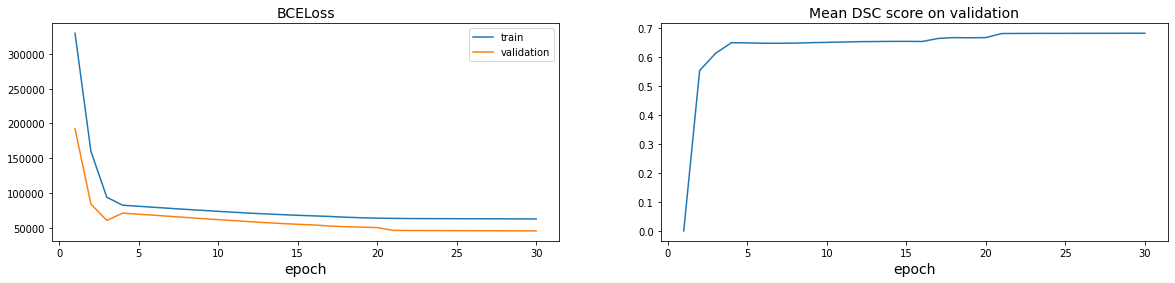

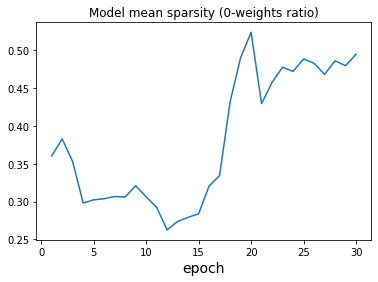

In [ ]:
show_results(results)

In [ ]:
get_accuracy(unet_mono, loaders['valid'], 'cuda:0')    

0.9900336877623601

In [ ]:
# saving the resulting images segmentation
# please replace 'unet_mono' with the path to existing empty folder
save_images(unet_mono, loaders, 'unet_mono')

# UNet monotone + L1 regularization

In [11]:
unet_mono_l1 = UNet(in_channels=BrainSegmentationDataset.in_channels, 
                 out_channels=BrainSegmentationDataset.out_channels,
                 init_features=32, p=0.1)

In [12]:
monotonize(unet_mono_l1)

In [13]:
res_mono_l1 = train_validate(unet_mono_l1, loaders, report_sparcity, l1=1e-1,
                             name='unet_mono_l1', lr=1e-2, monotonize=monotonize,
                              schedule='step', loss_func=torch.nn.BCELoss(reduction='sum'))

epoch 1 | loss: 361690.31026785716
epoch 1 | val_loss: 194566.3318452381
epoch 1 | val_dsc: 0.03759487099298885
epoch 2 | loss: 146908.25669642858
epoch 2 | val_loss: 92946.48102678571
epoch 2 | val_dsc: 0.39760486160056796
epoch 3 | loss: 99997.1025297619
epoch 3 | val_loss: 63813.63002232143
epoch 3 | val_dsc: 0.5781120125963539
epoch 4 | loss: 86989.38779761904
epoch 4 | val_loss: 72033.02306547618
epoch 4 | val_dsc: 0.6669065668551152
epoch 5 | loss: 85162.67963169643
epoch 5 | val_loss: 69969.80915178571
epoch 5 | val_dsc: 0.6666197482480918
epoch 6 | loss: 83315.30675223214
epoch 6 | val_loss: 67724.73344494047
epoch 6 | val_dsc: 0.6678636571278445
epoch 7 | loss: 81529.771875
epoch 7 | val_loss: 66038.19921875
epoch 7 | val_dsc: 0.6659479489384182
epoch 8 | loss: 79760.409765625
epoch 8 | val_loss: 64145.46168154762
epoch 8 | val_dsc: 0.6654420258960071
epoch 9 | loss: 78036.35671502976
epoch 9 | val_loss: 62559.343843005954
epoch 9 | val_dsc: 0.6637973924291974
epoch 10 | loss:

In [14]:
results = res_to_df(res_mono_l1, 'unet_mono_l1', mono='last_layer', l1=0.1)
results.to_csv('res_mono_l1.csv', index=False)

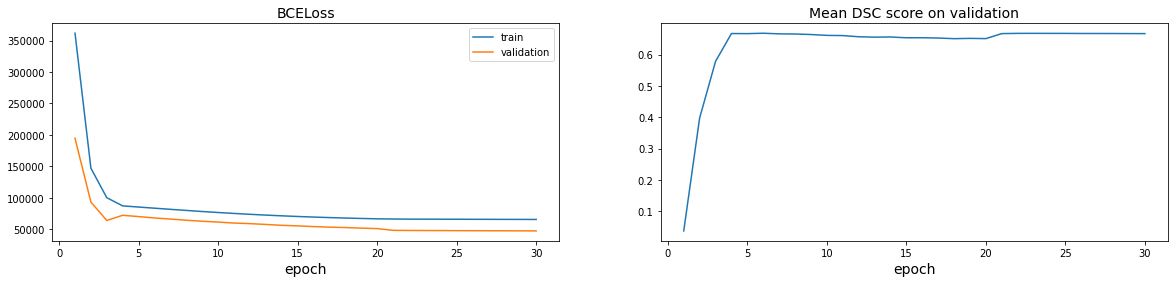

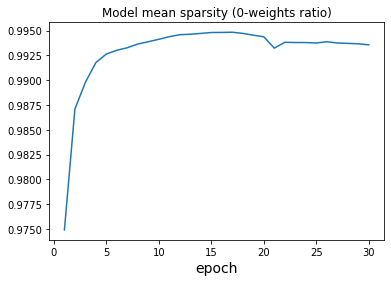

In [15]:
show_results(results)

In [16]:
get_accuracy(unet_mono_l1, loaders['valid'], 'cuda:0')

0.9897729218895756

In [21]:
# saving the resulting images segmentation
# please replace 'unet_mono_l1' with the path to existing empty folder
save_images(unet_mono_l1, loaders, 'unet_mono_l1')

# Results combination

In [23]:
res_unet = pd.read_csv('res.csv')
res_unet_mono = pd.read_csv('res_mono.csv')
res_unet_mono_l1 = pd.read_csv('res_mono_l1.csv')

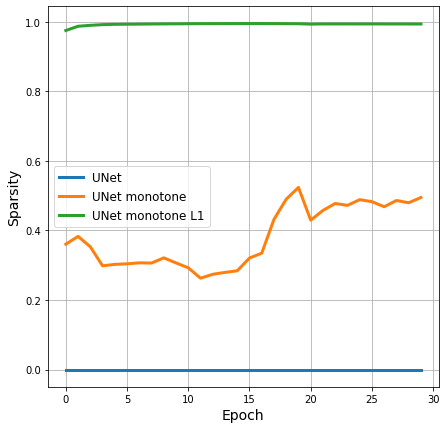

In [26]:
plt.figure(figsize=(7,7))
for name, data in zip(['UNet', 'UNet monotone', 'UNet monotone L1'],
                      [res_unet, res_unet_mono, res_unet_mono_l1]):
    plt.plot(data['mean_sparsity'], label=name, lw = 3);
plt.grid()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Sparsity", fontsize=14)

plt.legend(fontsize=12)    

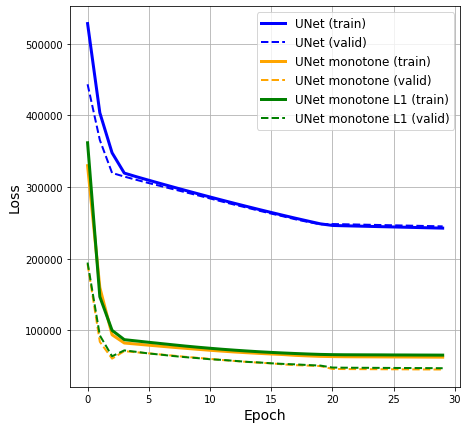

In [35]:
plt.figure(figsize=(7,7))
for name, data, c in zip(['UNet', 'UNet monotone', 'UNet monotone L1'],
                         [res_unet, res_unet_mono, res_unet_mono_l1],
                         ['b', 'orange', 'g']):
    plt.plot(data['train_mean_loss'], label=name + ' (train)', lw = 3, c=c)
    plt.plot(data['val_mean_loss'], label=name+' (valid)', lw = 2, linestyle='--', c=c)

plt.grid()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)

plt.legend(fontsize=12)    

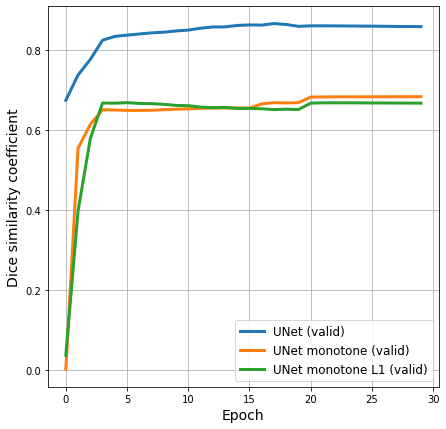

In [40]:
plt.figure(figsize=(7,7))
for name, data in zip(['UNet', 'UNet monotone', 'UNet monotone L1'],
                         [res_unet, res_unet_mono, res_unet_mono_l1]):
    plt.plot(data['mean_val_dsc'], label=name + ' (valid)', lw = 3)

plt.grid()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Dice similarity coefficient", fontsize=14)

plt.legend(fontsize=12)    

# Sanity check

Here we generate a monotone sequence and then check, that all except the last layers transform this sequence into monotone.


In [53]:
import numpy as np

def generate_monotone_sequence():
  im1 = np.random.rand(image_size**2 * 3) - .5
  im1 = im1.reshape((3, image_size, image_size))
  im2 = im1 + .1
  im3 = im1 + .2

  batch = np.stack([im1, im2, im3], axis=0)

  return torch.tensor(batch, dtype=torch.float32)

In [54]:
seq = generate_monotone_sequence()

In [55]:
# check that the sequence is monotone
np.all(np.diff(seq.reshape(3, -1), axis=0) > 0)

True

In [83]:
def check_monotonicity(self, input, output):
  is_mono = np.all(np.diff(input[0].cpu().detach().numpy().reshape(3, -1), axis=0) >= 0)
  print(f'Last layer has monotone input: {is_mono}')

## Checking that UNet_monotone and UNet_monotone + L1 are indeed input-monotone

In [84]:
handle = unet_mono_l1.conv.register_forward_hook(check_monotonicity)

In [85]:
_ = unet_mono_l1(seq.cuda())

Last layer has monotone input: True


In [86]:
handle.remove()

In [95]:
unet_mono = UNet(in_channels=BrainSegmentationDataset.in_channels, 
                 out_channels=BrainSegmentationDataset.out_channels,
                 init_features=32, p=0.1)
state_dict = torch.load(os.path.join('./', f"unet_mono.pt"))
unet_mono.load_state_dict(state_dict)
unet_mono.eval();

In [96]:
handle = unet_mono.conv.register_forward_hook(check_monotonicity)
_ = unet_mono(seq)
handle.remove()

Last layer has monotone input: True


## Checking that vanilla UNet is not monotone

In [97]:
unet = UNet(in_channels=BrainSegmentationDataset.in_channels, 
                 out_channels=BrainSegmentationDataset.out_channels,
                 init_features=32, p=0)

state_dict = torch.load(os.path.join('./', f"unet.pt"))
unet.load_state_dict(state_dict)
unet.eval();

In [98]:
handle = unet.conv.register_forward_hook(check_monotonicity)
_ = unet(seq)
handle.remove()

Last layer has monotone input: False
